<a href="https://colab.research.google.com/github/garedo/Machine-Learning/blob/main/sentiment_analysis_on_tweets_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Este notebook foi baseado no exemplo: [kaggle notebook](https://www.kaggle.com/viniciuscleves/an-lise-de-sentimento-com-bert). Sendo que foi adaptado para depois do treinamento realizar crawler no Twitter e fazer algumas predições.

Therefore, on this notebook I will:

1. Carregar os dados e utilizar apenas uma parte por limitação de tempo.
2. Treinar e avaliar em um classificador BERT.
3. Avaliar o modelo em dados em tempo real sobre as eleições. 

In [ ]:
!pip install transformers datasets --upgrade --quiet

     |████████████████████████████████| 5.3 MB 33.7 MB/s 
     |████████████████████████████████| 441 kB 60.6 MB/s 
     |████████████████████████████████| 7.6 MB 60.8 MB/s 
     |████████████████████████████████| 163 kB 55.6 MB/s 
     |████████████████████████████████| 212 kB 67.9 MB/s 
     |████████████████████████████████| 115 kB 74.0 MB/s 
     |████████████████████████████████| 127 kB 72.5 MB/s 
     |████████████████████████████████| 115 kB 50.2 MB/s 


Intalação de pacotes

In [ ]:
ddsd

In [ ]:
import math
import os
import pickle
import re
from dataclasses import dataclass

import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tqdm.notebook import tqdm
from transformers import (AdamW, AutoConfig, BertTokenizer,
                          DataCollatorWithPadding, AutoTokenizer, pipeline,
                          AutoModelForSequenceClassification, 
                          get_linear_schedule_with_warmup)

import os
from tqdm.notebook import tqdm
from google.colab import drive

datasets.logging.set_verbosity_error()
nltk.download('stopwords')
nltk.download('punkt')
tqdm.pandas()

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Montagem do drive para ter acesso aos dados**

In [ ]:
drive.mount('/content/gdrive')
base_path = "/content/gdrive/MyDrive/Minicurso ERI-GO/"

Mounted at /content/gdrive


# Carrega os dados de textos do Twitter


In [ ]:
def load_data():
    no_theme = pd.read_csv(base_path + 'data/NoThemeTweets.csv', index_col=0)
    no_theme['type'] = 'no_theme-'

    with_theme = pd.read_csv(base_path + 'data/TweetsWithTheme.csv', index_col=0)
    with_theme['type'] = 'with_theme-'

    data = pd.concat([no_theme, with_theme])
    data['type'] = data['type'] + data['sentiment']
    # Remove twetts duplicados
    data = data[~data.index.duplicated(keep='first')]
    
    dataset_size = 0.05
    discard, data = train_test_split(data, test_size=dataset_size, random_state=42, stratify=data['type'])
    
    neutrals = pd.read_csv(base_path + 'data/TweetsNeutralNews.csv', index_col=0)
    neutrals['type'] = 'neutrals-'
    
    dataset_size = 0.55
    discard, neutrals = train_test_split(neutrals, test_size=dataset_size, random_state=42, stratify=neutrals['type'])
    
    data = pd.concat([data, neutrals])
    
    return data

data = load_data()

condicoes = [
    data.sentiment.eq("Negativo"), 
    data.sentiment.eq("Positivo"),
    data.sentiment.eq("Neutro")
]

valores = [0, 1, 2]

data['labels'] = np.select(condicoes, valores)

In [ ]:
def clean_text(text):
    """
    Script used for cleaning corpus in order to train word embeddings.
    All emails are mapped to a EMAIL token.
    All numbers are mapped to 0 token.
    All urls are mapped to URL token.
    Different quotes are standardized.
    Different hiphen are standardized.
    HTML strings are removed.
    All text between brackets are removed.
    All sentences shorter than 5 tokens were removed.
    ...
    """
    sent_tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle')

    # Punctuation list
    punctuations = re.escape('!"#%\'()*+,./:;<=>?@[\\]^_`{|}~')

    # ##### #
    # Regex #
    # ##### #
    re_remove_brackets = re.compile(r'\{.*\}')
    re_remove_html = re.compile(r'<(\/|\\)?.+?>', re.UNICODE)
    re_transform_numbers = re.compile(r'\d', re.UNICODE)
    re_transform_usernames = re.compile(r'(^|[^@\w])@(\w{1,15})\b', re.UNICODE)
    re_transform_url = re.compile(r'(http|https)://[^\s]+', re.UNICODE)
    # Different quotes are used.
    re_quotes_1 = re.compile(r"(?u)(^|\W)[‘’′`']", re.UNICODE)
    re_quotes_2 = re.compile(r"(?u)[‘’`′'](\W|$)", re.UNICODE)
    re_quotes_3 = re.compile(r'(?u)[‘’`′“”]', re.UNICODE)
    re_dots = re.compile(r'(?<!\.)\.\.(?!\.)', re.UNICODE)
    re_punctuation = re.compile(r'([,";:]){2},', re.UNICODE)
    re_hiphen = re.compile(r' -(?=[^\W\d_])', re.UNICODE)
    re_tree_dots = re.compile(u'…', re.UNICODE)
    # Differents punctuation patterns are used.
    re_punkts = re.compile(r'(\w+)([%s])([ %s])' %
                           (punctuations, punctuations), re.UNICODE)
    re_punkts_b = re.compile(r'([ %s])([%s])(\w+)' %
                             (punctuations, punctuations), re.UNICODE)
    re_punkts_c = re.compile(r'(\w+)([%s])$' % (punctuations), re.UNICODE)
    re_changehyphen = re.compile(u'–')
    re_doublequotes_1 = re.compile(r'(\"\")')
    re_doublequotes_2 = re.compile(r'(\'\')')
    re_trim = re.compile(r' +', re.UNICODE)

    """Apply all regex above to a given string."""
    text = text.lower()
    text = re_tree_dots.sub('...', text)
    text = re.sub('\.\.\.', '', text)
    text = re_remove_brackets.sub('', text)
    text = re_changehyphen.sub('-', text)
    text = re_remove_html.sub(' ', text)
    text = re_transform_numbers.sub('0', text)
    text = re_transform_url.sub('URL', text)
    text = re_transform_usernames.sub(' username ', text)
    text = re_quotes_1.sub(r'\1"', text)
    text = re_quotes_2.sub(r'"\1', text)
    text = re_quotes_3.sub('"', text)
    text = re.sub('"', '', text)
    text = re_dots.sub('.', text)
    text = re_punctuation.sub(r'\1', text)
    text = re_hiphen.sub(' - ', text)
    text = re_punkts.sub(r'\1 \2 \3', text)
    text = re_punkts_b.sub(r'\1 \2 \3', text)
    text = re_punkts_c.sub(r'\1 \2', text)
    text = re_doublequotes_1.sub('\"', text)
    text = re_doublequotes_2.sub('\'', text)
    text = re_trim.sub(' ', text)
    return text.strip()

**Pré Processamento dos dados**


1.   Remoção de pontos
2.   Remoção de números
3.   Remoção de URLs
4.   Remover palavras e dígitos que contenham dígitos
5.   Remover nomes dos usuários
6.   *Expandir contrações*
7.   *Stopwords*
8.   *Stemming and Lemmatization*

Stemming
Reduz a palavra à sua raiz

Lemmatization
Reduz a palavra à sua raiz, retirando todas as inflexões

In [ ]:
data['tweet_text'] = data['tweet_text'].progress_apply(clean_text)

# Remove linhas com tamanho menor que 5
data["text_length"]= data["tweet_text"].str.len()
data = data[data["text_length"] > 5]
data.drop('text_length', axis=1, inplace=True)

  0%|          | 0/62367 [00:00<?, ?it/s]

In [ ]:
data.head()

,tweet_text,tweet_date,sentiment,query_used,type,labels
id,,,,,,
1037139518305062912,username eu gosto tanto de vc :(,Wed Sep 05 00:45:04 +0000 2018,Negativo,:(,no_theme-Negativo,0
1034460603849625600,musica : d url,Tue Aug 28 15:20:01 +0000 2018,Positivo,:),no_theme-Positivo,1
1030274394780848128,username username username username username u...,Fri Aug 17 02:05:31 +0000 2018,Positivo,:),no_theme-Positivo,1
1033561586600996864,"gente to mto triste socorro , fazem 0 horas q ...",Sun Aug 26 03:47:39 +0000 2018,Negativo,:(,no_theme-Negativo,0
1037424539163156480,tinha uma ideia para passar os meus 00 anos ma...,Wed Sep 05 19:37:39 +0000 2018,Negativo,:(,no_theme-Negativo,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62367 entries, 1037139518305062912 to 1035675825511776257
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  62367 non-null  object
 1   tweet_date  62367 non-null  object
 2   sentiment   62367 non-null  object
 3   query_used  62367 non-null  object
 4   type        62367 non-null  object
 5   labels      62367 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 3.3+ MB


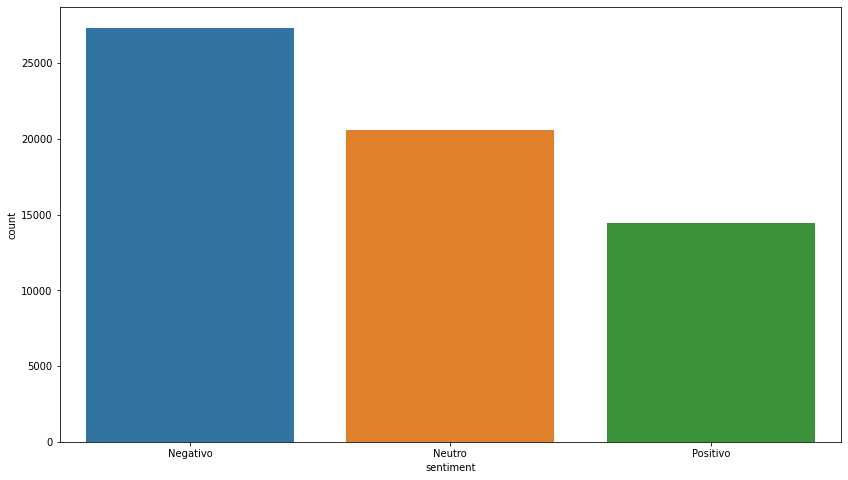

In [ ]:
plt.figure(figsize=(14, 8))
p = sns.countplot(data=data, x = 'sentiment', order = data['sentiment'].value_counts().index)

## Preparação dos dados para treinamento

In [ ]:
def create_splits(data):
    test_validation_size = 0.10
    train_validation, test = train_test_split(data, test_size=test_validation_size, random_state=42, stratify=data['type'])
    train, validation = train_test_split(train_validation, test_size=test_validation_size, random_state=42, stratify=train_validation['type'])
    return train, validation, test
train, validation, test = create_splits(data)

print('Training samples:  ', train.shape[0])
print('Validation samples:', validation.shape[0])
print('Test samples:      ', test.shape[0])

Training samples:   50517
Validation samples: 5613
Test samples:       6237


In [ ]:
def build_dataset(tokenizer, splits):
    train, validation, test = splits
    # Carrega do disco os Datasets, isso útil quando você tem um conjunto de dados muito grande que não cabe na memória
    train.to_csv('train_split.csv')
    validation.to_csv('validation_split.csv')
    test.to_csv('test_split.csv')
    dataset = datasets.load_dataset('csv', data_files={'train': 'train_split.csv',
                                                       'validation':'validation_split.csv',
                                                       'test': 'test_split.csv'})
    dataset = dataset.map(lambda example: {'unbiased_text': re.sub(r':[\)\(]+', '', example['tweet_text'])}, batched=False)
    dataset = dataset.map(lambda examples: tokenizer(examples['unbiased_text']), batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    
    return dataset

## Modelo Baseline

In [ ]:
stemmer = nltk.stem.snowball.PortugueseStemmer()
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc) if w[0]!='@')

vectorizer = TfidfVectorizer(
    stop_words=nltk.corpus.stopwords.words('portuguese'), 
    analyzer=stemmed_words,
    min_df=0.0001, 
    max_features=100000, 
    max_df=0.8)

X_train = vectorizer.fit_transform(train['tweet_text'].apply(lambda s: re.sub(r':[\)\(]+', '', s)))
X_validation = vectorizer.transform(validation['tweet_text'].apply(lambda s: re.sub(r':[\)\(]+', '', s)))
X_test = vectorizer.transform(test['tweet_text'].apply(lambda s: re.sub(r':[\)\(]+', '', s)))

y_train = train['labels'].values
y_validation = validation['labels'].values
y_test = test['sentiment'].values

In [ ]:
target_names = data['sentiment'].unique()

In [ ]:
lr = LogisticRegression(random_state=0, class_weight='balanced', max_iter=500, verbose=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_validation)

print(classification_report(y_validation, y_pred, target_names=target_names))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

    Negativo       0.85      0.76      0.80      2460
    Positivo       0.62      0.70      0.66      1302
      Neutro       0.95      0.99      0.97      1851

    accuracy                           0.82      5613
   macro avg       0.80      0.82      0.81      5613
weighted avg       0.83      0.82      0.82      5613



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished


In [ ]:
!nvidia-smi

Wed Oct 26 18:12:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Treinamento do modelo (BERT)

Funções helpers:


*   Calcula métricas de avaliação do modelo
*   Envia os dados para o device



In [ ]:
def compute_metrics(preds, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def send_inputs_to_device(inputs, device):
    return {key:tensor.to(device) for key, tensor in inputs.items()}

Carrega o modelo base, define um otimizador, um escalonador para controlar a taxa de aprendizado, para a realização do treinamento

In [ ]:
id2label, label2id = {}, {}

for i, key in enumerate(data.sentiment.unique()):
  id2label[i] = key
  label2id[key] = i

In [ ]:
num_epochs = 1
num_warmup_steps = 5000
num_labels = len(data.sentiment.unique())
model_base = "neuralmind/bert-base-portuguese-cased"

tokenizer = BertTokenizer.from_pretrained(model_base)
model = AutoModelForSequenceClassification.from_pretrained(model_base, num_labels = num_labels)
config = AutoConfig.from_pretrained(model_base, num_labels = num_labels, finetuning_task = None)

#Configurar o de para classes para o model Bert\
model.config.id2label = id2label
model.config.label2id = label2id

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.train().to(device)

optimizer = AdamW(model.parameters(), lr = 5e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_epochs*len(train))

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Configurando os dados com o tokenizadores do Huggingface o modelo base para o finetunning.

In [ ]:
dataset = build_dataset(tokenizer, (train, validation, test))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-37d26f1fc243845e/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50517 [00:00<?, ?ex/s]

  0%|          | 0/5613 [00:00<?, ?ex/s]

  0%|          | 0/6237 [00:00<?, ?ex/s]

  0%|          | 0/51 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

"Carregadores" dos dados

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))
validation_loader = torch.utils.data.DataLoader(dataset['validation'], batch_size=32, collate_fn=DataCollatorWithPadding(tokenizer))
test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=32, collate_fn=DataCollatorWithPadding(tokenizer))

Função para realização da predição

In [ ]:
def predict(model, validation_loader, device):
    with torch.no_grad():
        model.eval()
        preds = []
        labels = []
        validation_losses = []
        for inputs in tqdm(validation_loader):
            labels.append(inputs['labels'].numpy())
            
            inputs = send_inputs_to_device(inputs, device)
            loss, scores = model(**inputs)[:2]
            validation_losses.append(loss.cpu().item())

            _, classifications = torch.max(scores, 1)
            preds.append(classifications.cpu().numpy())
        model.train()
    return np.concatenate(preds), np.concatenate(labels)

Treinamento do modelo

In [ ]:
epoch_bar = tqdm(range(num_epochs))
loss_acc = 0
alpha = 0.95
for epoch in epoch_bar:
  batch_bar = tqdm(enumerate(train_loader), desc = f'Epoch {epoch}', total = len(train_loader))
  for idx, inputs in batch_bar:
    inputs = send_inputs_to_device(inputs, device)
    #define os gradientes como zero antes de começar a fazer
    #retropropagação
    #porque o PyTorch acumula os gradientes em passagens
    #posteriores subsequentes
    optimizer.zero_grad()

    loss, logits = model(**inputs)[:2]

    #Calcula a perda (backpropagation)
    loss.backward()

    #Executa uma atualização de parâmetro com base no gradiente atual
    optimizer.step()

    #Calcula a loss para exibição
    if epoch == 0 and idx == 0:
      loss_acc = loss.cpu().item()
    else:
      loss_acc = loss_acc * alpha + (1-alpha) * loss.cpu().item()

    batch_bar.set_postfix(loss = loss_acc)

    if idx%2000 == 0:
      preds, labels = predict(model, validation_loader, device)
      metrics = compute_metrics(preds, labels)
      print(metrics)
    scheduler.step()

  model.save_pretrained(base_path + 'checkpoints/epoch' + str(epoch))
  

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/3158 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

{'accuracy': 0.4436130411544629, 'f1': 0.32354877276741434, 'precision': 0.41664817846702795, 'recall': 0.4436130411544629}


  0%|          | 0/176 [00:00<?, ?it/s]

{'accuracy': 0.8528416176732585, 'f1': 0.8420977360927798, 'precision': 0.8545669207162804, 'recall': 0.8528416176732585}


Avaliação do modelo nos dados de testes

In [ ]:
preds, labels = predict(model, test_loader, device)

print(classification_report(labels, preds, target_names = target_names))

  0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negativo       0.86      0.88      0.87      2734
    Positivo       0.76      0.72      0.74      1447
      Neutro       0.99      1.00      0.99      2056

    accuracy                           0.88      6237
   macro avg       0.87      0.86      0.87      6237
weighted avg       0.88      0.88      0.88      6237



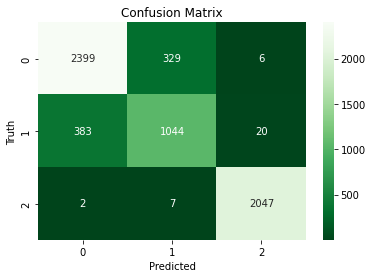

In [ ]:
ax = sns.heatmap(confusion_matrix(labels, preds), cmap='Greens_r', annot=True, fmt='d')
_ = ax.set(xlabel='Predicted', ylabel='Truth', title='Confusion Matrix')

# Avaliar modelo em dados recentes sobre as eleições


In [ ]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import tweepy as tweepy
import sqlite3
import json
import sys

In [ ]:
with open(base_path + "credentials.json", "r") as f:
    credentials = json.loads(f.read())

In [ ]:
# Security keys to my app Twitter
consumer_key = credentials["consumer_key"]
consumer_secret = credentials["consumer_secret"]
access_token = credentials["access_token"]
access_token_secret = credentials["access_token_secret"]

In [ ]:
# Auth on Twitter
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
# Classe de captura dados no Twitter e armazenar em um banco de dados SQLite
class TwitterListener(StreamListener):
    exclusion = 'ao vivo'

    def __init__(self):
        self.conn = sqlite3.connect('gdrive/MyDrive/Colab_Notebooks/erigo_2022/twitter_eleicoes.db')

    def on_data(self, dados):
        tweet = json.loads(dados)
        created_at = tweet["created_at"]
        id_str = tweet["id_str"]
        text = tweet["text"]

        if (text.lower().find(self.exclusion) >= 0 and text.lower().find('rt') >= 0):
            return True

        try:
            # Evita dados duplicados
            cur = self.conn.cursor()
            cur.execute("SELECT COUNT(id) FROM tweet WHERE id = ? OR text = ?", (id_str , text))
            for linha in cur.fetchall():
                if (linha[0] > 0):
                    return True

            cur.close()

            cur = self.conn.cursor()
            sql_insert = 'INSERT INTO tweet(id, text) VALUES (?, ?)'
            rec = (id_str, text)
            cur.execute(sql_insert, rec)
            self.conn.commit()
        except Exception as ex:
            self.conn.commit()
            self.conn.close()
            print(ex)
        
        return True

    def on_status(self, status):
        print(status.text)
        
    def on_error(self, status_code):
        print(status_code)

In [ ]:
keywords = ['Bolsonaro', 'Lula']

In [ ]:
# Creating the listener
twitterlistener = TwitterListener()

# Creating the twitterstream object
twitterstream = Stream(auth = api.auth, listener = twitterlistener)

In [ ]:
# Starting the filter and saving the tweets in SQLite
twitterstream.filter(languages=["pt"], track=keywords)

In [ ]:
twitterstream.disconnect()

In [ ]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(base_path + "data/twitter_eleicoes.db")
df = pd.read_sql_query("SELECT * FROM tweet", con)
con.close()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           417 non-null    object
 1   text         417 non-null    object
 2   label_value  0 non-null      object
 3   label        0 non-null      object
dtypes: object(4)
memory usage: 13.2+ KB


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
df.loc[:,['id', 'text']].head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,id,text
0,1584390960414593025,"RT @ptbrasil: ""Assim como o senhor @LulaOficial tá assinando minha carteira, eu sei que daqui pra frente vão ter muitos brasileiros com car…"
1,1584390960670117888,RT @AndreJanonesAdv: URGENTE! Movimentação intensa aqui nos arredores do palácio do alvorada neste momento. Me hospedei próximo estrategica…
2,1584390960712388608,"RT @RachelSherazade: Enquanto Roberto Jefferson ocupa o noticiário, Paulo Guedes, o ministro de Bolsonaro, segue seu projeto de enfraquecer…"
3,1584390960707817472,"RT @LulaPelaVerdade: Em entrevista à Record, Bolsonaro despejou seu habitual caminhão de mentiras.\n\nForam pelo menos 37 ataques mentirosos…"
4,1584390961328984064,"RT @GugaNoblat: Quando Lula foi preso depois de um julgamento que ele dizia ilegal e depois se mostrou ilegal, ele não atirou. Quando Dilma…"
5,1584390961542537217,"RT @_Janoninho: Filha de Roberto Jefferson admite que pai pode pedir indulto a Bolsonaro: 'Se precisar, ele vai nos ajudar'. O Globo"
6,1584390961526099969,LULA não e mais lula.agora é vulgo FUJAO🤣🤣🤣🤣👍🏿👍🏿
7,1584390960754003969,Maior acerto de Lula naquele debate foi enquadrar esse falso padre picareta. Disse naquela ocasião e repito hoje. E… https://t.co/MaKIpfn1XX
8,1584390962260094976,"RT @felipeneto: Vcs têm noção q se os policiais federais tivessem caído na isca e atirado de volta no Roberto Jeff, bolsonaro teria consegu…"
9,1584390962637590528,"RT @taoquei1: O arregao desesperado não vai ao debate e vai dar 1h de sabatina ao presidente Bolsonaro na Record hj, as 21:30. Divulguem.\n#…"


In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
path_of_model = base_path + 'checkpoints/epoch0'
model = AutoModelForSequenceClassification.from_pretrained(path_of_model)

In [ ]:
nlp = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)

In [ ]:
for index, row in df.iterrows():
  text_sentence = row[1]
  result = nlp(text_sentence)
  print(row[0], result)

  if index == 10:
    break

1584390960414593025 [{'label': 'Positivo', 'score': 0.7700322270393372}]
1584390960670117888 [{'label': 'Positivo', 'score': 0.90633225440979}]
1584390960712388608 [{'label': 'Positivo', 'score': 0.42576947808265686}]
1584390960707817472 [{'label': 'Positivo', 'score': 0.5561563968658447}]
1584390961328984064 [{'label': 'Positivo', 'score': 0.5891438126564026}]
1584390961542537217 [{'label': 'Neutro', 'score': 0.9897881746292114}]
1584390961526099969 [{'label': 'Positivo', 'score': 0.591251790523529}]
1584390960754003969 [{'label': 'Positivo', 'score': 0.790730893611908}]
1584390962260094976 [{'label': 'Positivo', 'score': 0.7002449631690979}]
1584390962637590528 [{'label': 'Positivo', 'score': 0.8522172570228577}]
1584390962868293632 [{'label': 'Positivo', 'score': 0.7622814774513245}]


# Conclusão

Os modelos de língua tem melhores resultados do que modelos de baseline.

**Obrigado!**